In [137]:
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit

In [138]:
path="C:/Hariom Mehta/Academics/Masters MIS docs/SEM 3/BIA 656/Final Project/sofr_raw_data.xls"
df = pd.read_excel(path)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 8 columns):
DATE                    660 non-null object
 BENCHMARK NAME         660 non-null object
RATE
(PERCENT)          660 non-null float64
1ST
(PERCENT)           659 non-null float64
25TH
(PERCENT)          659 non-null float64
75TH
(PERCENT)          659 non-null float64
99TH
(PERCENT)          659 non-null float64
VOLUME (US$BILLIONS)    660 non-null object
dtypes: float64(5), object(3)
memory usage: 41.4+ KB


,RATE\n(PERCENT),1ST\n(PERCENT),25TH\n(PERCENT),75TH\n(PERCENT),99TH\n(PERCENT)
count,660.000000,659.000000,659.000000,659.000000,659.000000
mean,1.531939,1.463763,1.508012,1.584613,1.677815
std,0.925336,0.893740,0.921982,0.943244,1.004444
min,0.010000,-0.030000,0.010000,0.010000,0.120000
25%,0.110000,0.070000,0.080000,0.150000,0.215000
50%,1.855000,1.800000,1.820000,1.910000,1.980000
75%,2.262500,2.160000,2.240000,2.320000,2.410000
max,5.250000,2.700000,5.000000,5.850000,9.000000


In [139]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['DATE']

0     2018-04-02
1     2018-04-03
2     2018-04-04
3     2018-04-05
4     2018-04-06
         ...    
655   2020-11-12
656   2020-11-13
657   2020-11-16
658   2020-11-17
659   2020-11-18
Name: DATE, Length: 660, dtype: datetime64[ns]

In [140]:
df.isnull().sum()

DATE                    0
 BENCHMARK NAME         0
RATE\n(PERCENT)         0
1ST\n(PERCENT)          1
25TH\n(PERCENT)         1
75TH\n(PERCENT)         1
99TH\n(PERCENT)         1
VOLUME (US$BILLIONS)    0
dtype: int64

In [142]:
#we dont need percentile values, so we are dropping those columns
df_dropped = df.drop(["1ST\n(PERCENT)","25TH\n(PERCENT)","75TH\n(PERCENT)","99TH\n(PERCENT)"], axis =1)
df_dropped.isnull().sum()
df_dropped.to_csv(r'C:/Hariom Mehta/Academics/Masters MIS docs/SEM 3/BIA 656/Final Project/sofr_.csv',index=False)

In [151]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')


In [152]:
path = 'C:/Hariom Mehta/Academics/Masters MIS docs/SEM 3/BIA 656/Final Project/sofr_.csv'
new_df = pd.read_csv(path, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
new_df = new_df.asfreq(pd.infer_freq(new_df.index))

In [153]:
rate = new_df['RATE\n(PERCENT)']
rate.tail(20) 

DATE
2020-10-30    0.09
2020-10-31     NaN
2020-11-01     NaN
2020-11-02    0.11
2020-11-03    0.10
2020-11-04    0.10
2020-11-05    0.11
2020-11-06    0.10
2020-11-07     NaN
2020-11-08     NaN
2020-11-09    0.10
2020-11-10    0.10
2020-11-11     NaN
2020-11-12    0.09
2020-11-13    0.09
2020-11-14     NaN
2020-11-15     NaN
2020-11-16    0.10
2020-11-17    0.09
2020-11-18    0.07
Freq: D, Name: RATE\n(PERCENT), dtype: float64

### Since it parse all the continuous dates but Federal Bank remains close on public holidays and sat,sun it shows NaN values for those days. For better visualization of data we are going to fill the Nan values by it's previous day's rate. 


In [154]:
rate = rate.fillna(method='ffill')
rate = rate.pct_change().dropna()

In [155]:
#plt.figure(figsize=(10,4))
#plt.plot(series)
#plt.title('Simulated GARCH(2,2) Data', fontsize=20)

In [156]:
def plot_series(series):
    plt.figure(figsize=(12,6))
    plt.plot(rate, color='red')
    plt.ylabel('Search Frequency for Rate', fontsize=16)

    for year in range(2018, 2021):
        for month in range(1,13):
            plt.axvline(datetime(year,month,1), linestyle='--', color='k', alpha=0.5)

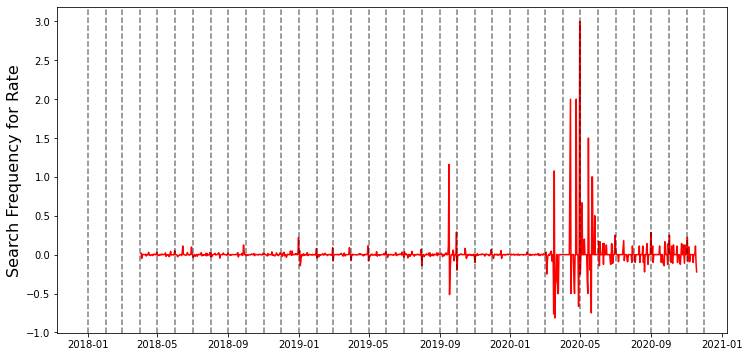

In [157]:
plot_series(rate)
#by the plot we can see some high volatility in behaviour of graph, there is some arch effect 

### Normalizing 

In [158]:
avg, dev = rate.mean(), rate.std()
rate = (rate - avg) / dev

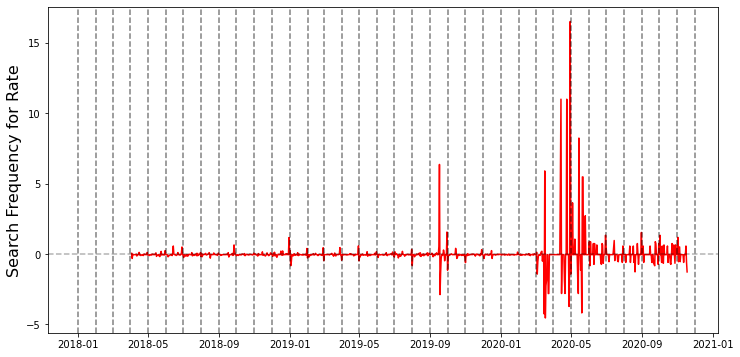

In [159]:
plot_series(rate)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

#### Taking First difference to remove the trend

In [160]:
rate = rate.diff().dropna()

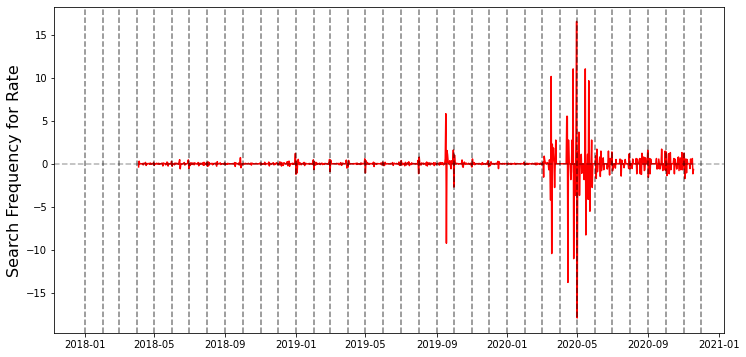

In [161]:
plot_series(rate)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

#### Removing Seasonality

In [162]:
month_avgs = rate.groupby(rate.index.month).mean()

In [163]:
month_avgs

DATE
1    -0.011904
2    -0.000343
3    -0.007880
4     0.198080
5    -0.180963
6     0.009813
7    -0.009277
8     0.012623
9     0.007819
10   -0.026603
11   -0.013414
12    0.018512
Name: RATE\n(PERCENT), dtype: float64

In [164]:
rate_month_avg = rate.index.map(lambda d: month_avgs.loc[d.month])

In [165]:
rate_month_avg

Float64Index([  0.19808035826070952,   0.19808035826070952,
                0.19808035826070952,   0.19808035826070952,
                0.19808035826070952,   0.19808035826070952,
                0.19808035826070952,   0.19808035826070952,
                0.19808035826070952,   0.19808035826070952,
              ...
              -0.013413670537628408, -0.013413670537628408,
              -0.013413670537628408, -0.013413670537628408,
              -0.013413670537628408, -0.013413670537628408,
              -0.013413670537628408, -0.013413670537628408,
              -0.013413670537628408, -0.013413670537628408],
             dtype='float64', name='DATE', length=960)

In [166]:
rate = rate - rate_month_avg

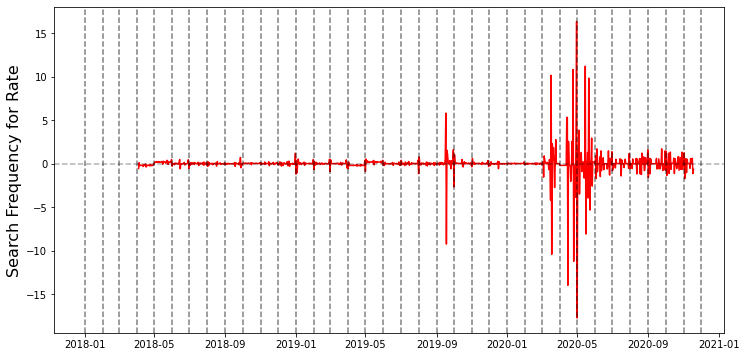

In [167]:
plot_series(rate)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

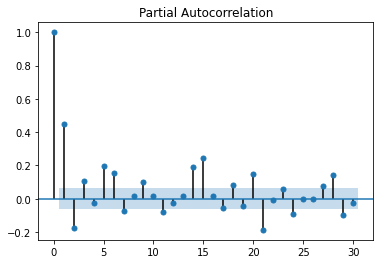

In [168]:
plot_pacf(np.array(rate)**2)
plt.show()

#reason to garch(2,2) model 

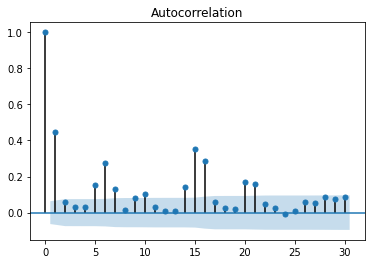

In [170]:
plot_acf(np.array(rate)**2)
plt.show()
##there is seroial corelationat lag 1 and 2 